## 1 Elements preprocessing

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import momepy as mm
import osmnx as ox
import numpy as np
from shapely.geometry import box
import utils

In [ ]:
# Read and preview data

df = pd.read_csv('./bue/bue_buildings.csv')
df.head()

In [3]:
# Project to UTM
from shapely import wkt

df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
buildings = gpd.GeoDataFrame(df, geometry='geometry', crs = 'EPSG:4326')
buildings = buildings.to_crs(32737)

In [4]:
buildings.crs

<Derived Projected CRS: EPSG:32737>
Name: WGS 84 / UTM zone 37S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 36°E and 42°E, southern hemisphere between 80°S and equator, onshore and offshore. Kenya. Mozambique. Tanzania.
- bounds: (36.0, -80.0, 42.0, 0.0)
Coordinate Operation:
- name: UTM zone 37S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# Clip building into AOI
clip_extent = gpd.read_file('./bue/bue_extent.geojson').to_crs(buildings.crs)
print("clip extent coordinate:", clip_extent.crs)

buildings = gpd.clip(buildings, clip_extent)
len(buildings)

clip extent coordinate: epsg:32737


8354783

In [6]:
# Check and correct geometries
buildings.geometry = buildings.buffer(0)
buildings = buildings[~buildings.geometry.isna()]
buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)

/tmp/ipykernel_3667/2697184569.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  buildings = buildings.reset_index(drop=True).explode().reset_index(drop=True)


In [7]:
# Count the number of buildings again

buildings.geom_type.value_counts()

Polygon    8354817
dtype: int64

In [8]:
# Fill islands within polygons

buildings = gpd.GeoDataFrame(geometry=utils.fill_insides(buildings))
buildings["uID"] = range(len(buildings))
buildings.crs

<Derived Projected CRS: EPSG:32737>
Name: WGS 84 / UTM zone 37S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 36°E and 42°E, southern hemisphere between 80°S and equator, onshore and offshore. Kenya. Mozambique. Tanzania.
- bounds: (36.0, -80.0, 42.0, 0.0)
Coordinate Operation:
- name: UTM zone 37S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Save to *.pq

buildings.to_parquet('buildings_1.pq')

In [10]:
# Save also to *.shp

buildings.to_file('buildings.shp')

#buildings = gpd.read_file('buildings-Copy1.shp')

In [11]:
# Preview the data attribute

buildings.head()

,geometry,uID
0,"POLYGON ((-6824121.856 -1301802.759, -6824121....",0
1,"POLYGON ((-6819968.518 -1301468.143, -6819959....",1
2,"POLYGON ((-6820004.320 -1301422.465, -6819994....",2
3,"POLYGON ((-6820043.955 -1301400.748, -6820035....",3
4,"POLYGON ((-6820076.592 -1301382.329, -6820058....",4


<AxesSubplot: >

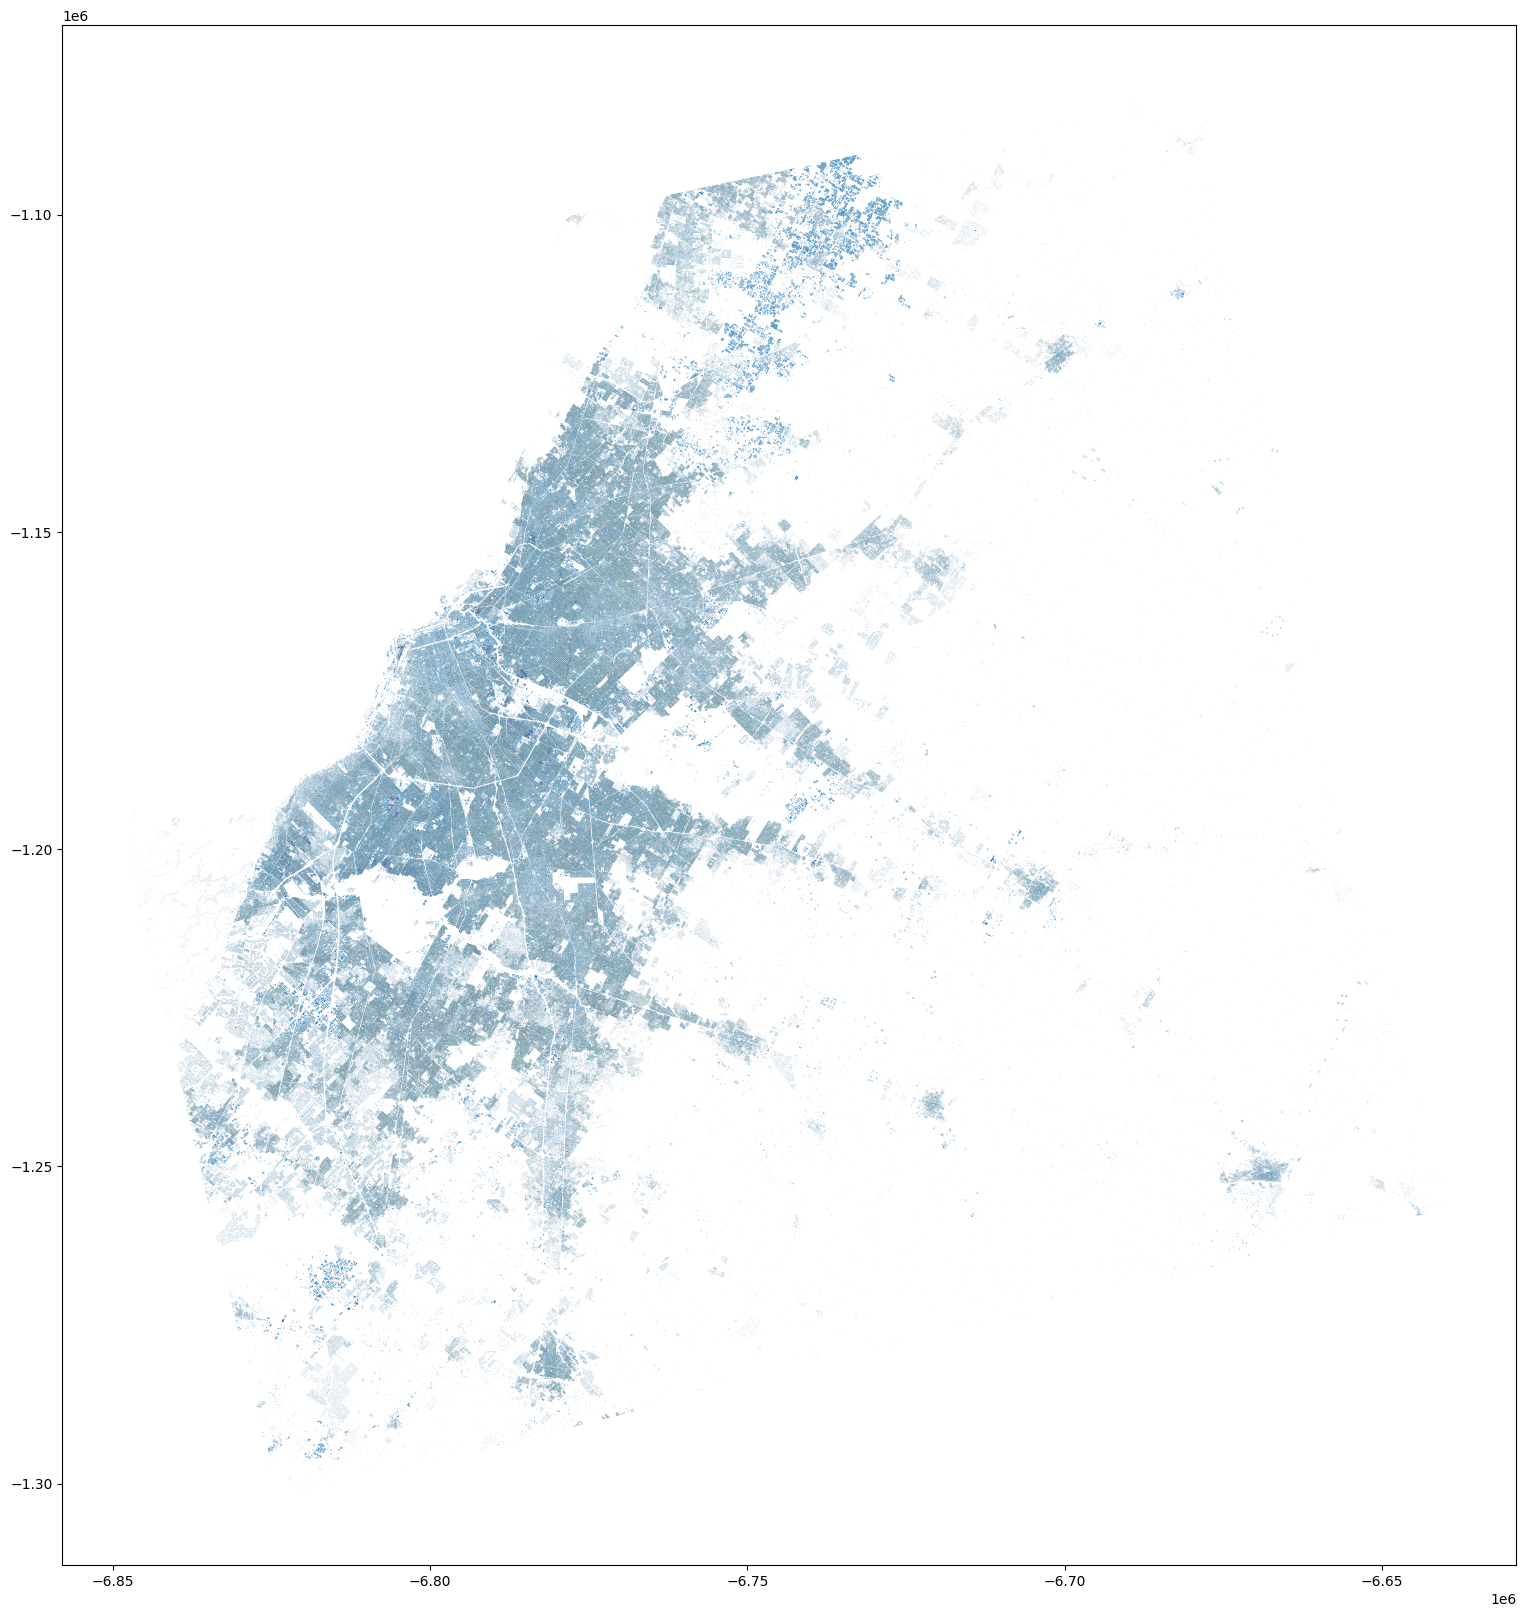

In [12]:
# Plot the geometry

buildings.plot(figsize=(20,20))

## 2 Tessellation

In [13]:
# Check validity of input

check = mm.CheckTessellationInput(buildings)

Collapsed features  : 62
Split features      : 93
Overlapping features: 4662


In [14]:
# Drop invalid elements

buildings = buildings.drop(check.collapse.index.union(check.overlap.index).union(check.split.index))

In [ ]:
# Tessellation

limit = mm.buffered_limit(buildings, 100)
%time tess = mm.Tessellation(buildings, "uID", limit, segment=2).tessellation

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [ ]:
# Save to *.pq

tess.to_parquet('tessellation.pq')

In [ ]:
# Count the number of tessellation

tess.shape

In [ ]:
# Plot the geometry

tess.plot(figsize=(20,20))

## 3 Morphometrics

In [ ]:
import geopandas as gpd
import momepy as mm
from tqdm import tqdm
from momepy import limit_range
import numpy as np
import pandas as pd
from inequality.theil import Theil
import libpysal
import scipy as sp
import mapclassify
import mapclassify.classifiers as classifiers

In [ ]:
# Read preprocessed data: buildings and tessellation

blg = gpd.read_parquet('buildings_1.pq')
#streets = gpd.read_parquet('edges.pq')
tess = gpd.read_parquet('tessellation.pq')
#blocks = gpd.read_parquet('blocks.pq')

In [ ]:
# Few metrics computed over building footprint, please refer to the online documentations about the functionalities

blg['sdbAre'] = mm.Area(blg).series
blg['sdbPer'] = mm.Perimeter(blg).series
blg['ssbCCo'] = mm.CircularCompactness(blg, 'sdbAre').series
blg['ssbCor'] = mm.Corners(blg).series
blg['ssbSqu'] = mm.Squareness(blg).series
blg['ssbERI'] = mm.EquivalentRectangularIndex(blg, 'sdbAre', 'sdbPer').series
blg['ssbElo'] = mm.Elongation(blg).series

In [ ]:
# Few more metrics computed over buildings and tessellations, again, please refer to the online documentations of the functions.

blg['stbOri'] = mm.Orientation(blg).series
tess['stcOri'] = mm.Orientation(tess).series
blg['stbCeA'] = mm.CellAlignment(blg, tess, 'stbOri', 'stcOri', 'uID', 'uID').series

tess['sdcLAL'] = mm.LongestAxisLength(tess).series
tess['sdcAre'] = mm.Area(tess).series
tess['sscCCo'] = mm.CircularCompactness(tess, 'sdcAre').series
tess['sscERI'] = mm.EquivalentRectangularIndex(tess, 'sdcAre').series
tess['sicCAR'] = mm.AreaRatio(tess, blg, 'sdcAre', 'sdbAre', 'uID').series

In [ ]:
# View computed metrics attached to the attribute table

blg.head()

In [ ]:
tess.head()

In [ ]:
# Save the computed metrics seperately, NOT along with the geometries (polygons)

blg.drop(columns='geometry').to_parquet('blg_data.parquet')
tess.drop(columns='geometry').to_parquet('tess_data.parquet')

In [ ]:
# We can also save the computed metrics of buildings and tessellations together

merged = tess.merge(blg.drop(columns=['geometry']), on='uID')

primary = merged.drop(columns=['geometry'])
primary.to_parquet('primary.parquet')

In [ ]:
# Many different way to save the results, according to your own preference.
# For easy visualization, we can also attach all the metrics to the building attribute table, and save it as a *.shp file for external visualization in other GIS softwares.

merged2 = blg.merge(tess.drop(columns=['geometry']), on='uID')

merged2.to_file('buildings_metrics.shp')

In [ ]:
# View the table of saved *.shp file

merged2.head()

In [ ]:
# Plot the morphometrics

merged2.plot(figsize=(20,20))

In [ ]:
merged.columns